In [1]:
import pandas as pd
# numpy, matplotlib, seaborn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

from sklearn.cross_validation import train_test_split,cross_val_score
from sklearn.metrics import roc_curve,auc
from sklearn import cross_validation
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn import metrics
import time
from IPython.display import Image

//Users/jonathanbouchet/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
dataBackground = pd.read_csv("/Users/jonathanbouchet/Desktop/WORK/STAR/SSD/TRACKING/D0_MachineLearning/background.csv",sep=',')
dataSignal = pd.read_csv("/Users/jonathanbouchet/Desktop/WORK/STAR/SSD/TRACKING/D0_MachineLearning/prepareSignal/signal.csv",sep=',')
print 'background sample size :',dataBackground.shape
print 'signal sample size :',dataSignal.shape

background sample size : (10016, 12)
signal sample size : (6344, 12)


In [4]:
result = dataBackground.append(dataSignal, ignore_index=True)
result.shape
featuresAll = ["dcaDaughters","pointingAngle","dcaK","dcaPi","cosThetaStar","ptK","ptPi","decayLength","particleID"]
tempo = result[featuresAll]

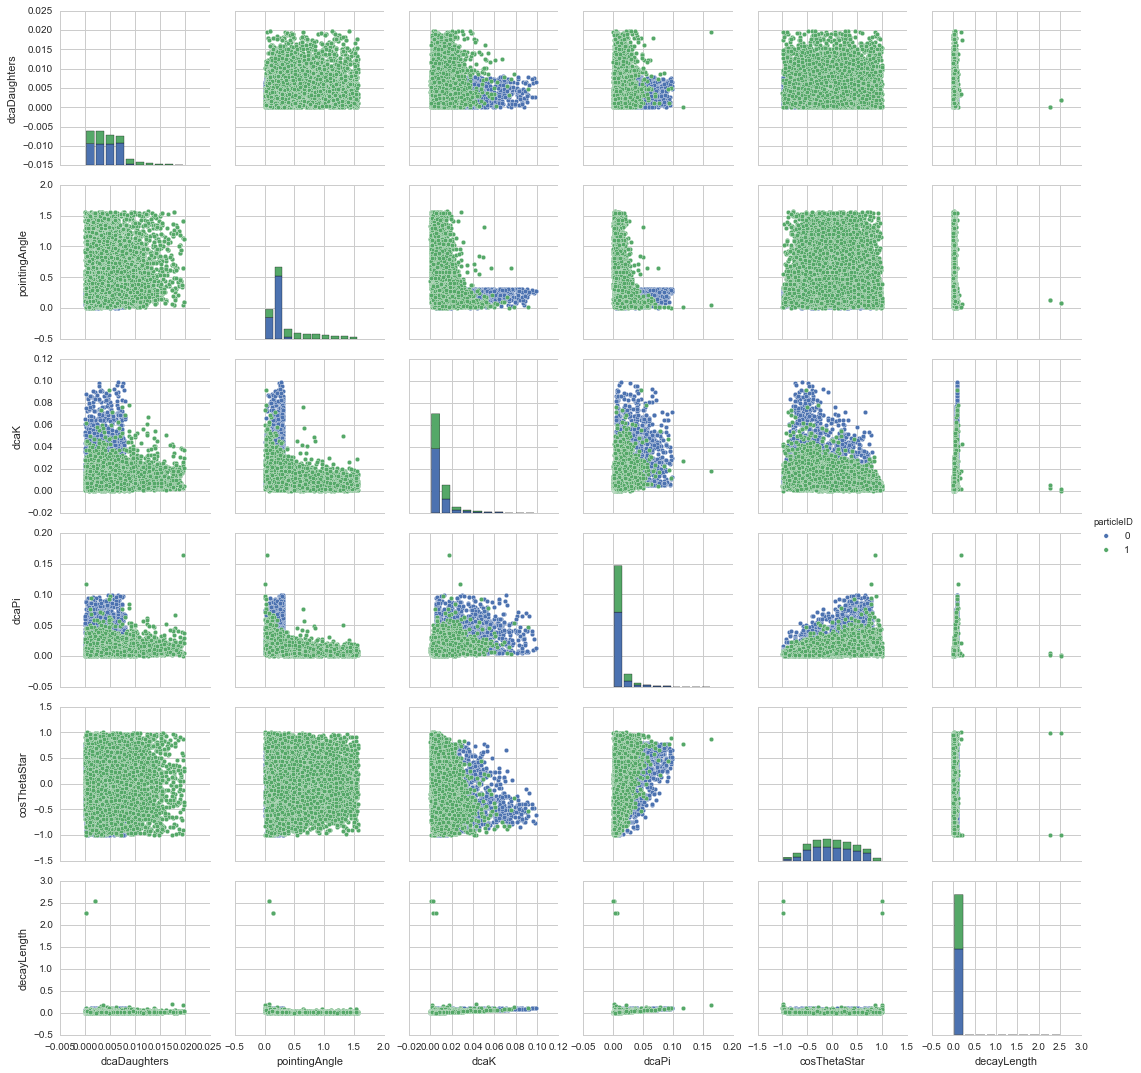

In [5]:
g = sns.pairplot(tempo, hue="particleID", vars=['dcaDaughters','pointingAngle','dcaK','dcaPi','cosThetaStar','decayLength'])

outliers :
    <ul>
    <li> decayLength >1 cm for particleID=1
    <li> dcaPi>0.1 cm for particleID=1
    </ul>

In [6]:
#fig = sns.FacetGrid(tempo, hue="particleID",aspect=5)
#fig.map(sns.kdeplot,'decayLength',shade= True)
#oldest = tempo['decayLength'].max()
#fig.set(xlim=(0,oldest))
#fig.add_legend()

In [7]:
#tempo.decayLength[tempo.particleID==0].hist(bins=100)

In [8]:
#tempo.decayLength[tempo.particleID==1].hist(bins=100)

We plot the decayLength and dcaPi, independantly for the the class. As seen above with the pair plot, the outliers 
are only for class=1

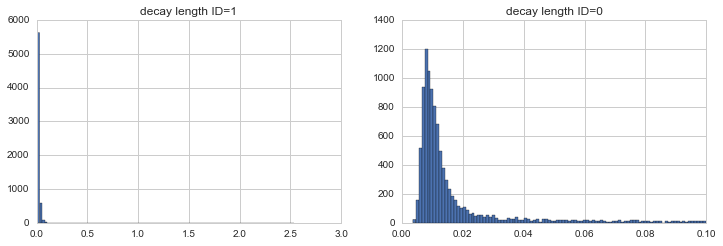

In [9]:
plt.figure(figsize=(12,8))
plt.subplot(2, 2, 1)
tempo.decayLength[tempo.particleID==1].hist(bins=100)
plt.title('decay length ID=1')

plt.subplot(2, 2, 2)
tempo.decayLength[tempo.particleID==0].hist(bins=100)
plt.title('decay length ID=0')
plt.show()

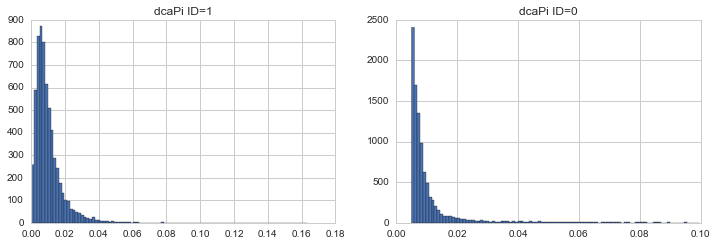

In [10]:
plt.figure(figsize=(12,8))
plt.subplot(2, 2, 1)
tempo.dcaPi[tempo.particleID==1].hist(bins=100)
plt.title('dcaPi ID=1')

plt.subplot(2, 2, 2)
tempo.dcaPi[tempo.particleID==0].hist(bins=100)
plt.title('dcaPi ID=0')
plt.show()

We then remove these entries (the statistics of both sample is enough to do so)

In [11]:
tempo = tempo.drop(tempo[tempo.decayLength > 0.1].index)
tempo = tempo.drop(tempo[tempo.dcaPi > 0.1].index)

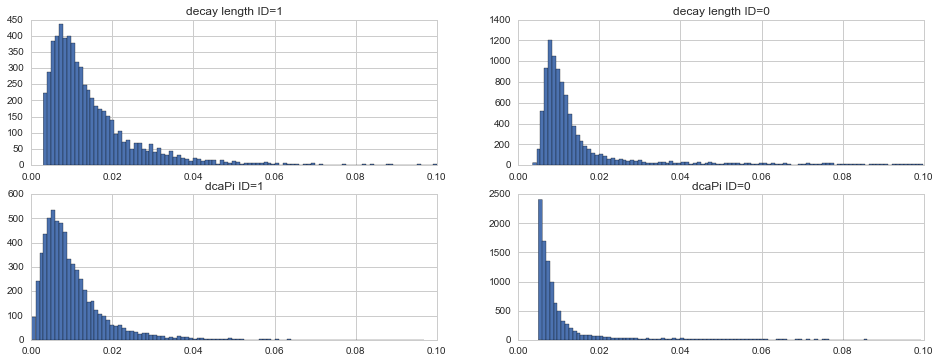

In [12]:
#re-check
plt.figure(figsize=(16,12))
plt.subplot(4, 2, 1)
tempo.decayLength[tempo.particleID==1].hist(bins=100)
plt.title('decay length ID=1')

plt.subplot(4, 2, 2)
tempo.decayLength[tempo.particleID==0].hist(bins=100)
plt.title('decay length ID=0')

plt.subplot(4, 2, 3)
tempo.dcaPi[tempo.particleID==1].hist(bins=100)
plt.title('dcaPi ID=1')

plt.subplot(4, 2, 4)
tempo.dcaPi[tempo.particleID==0].hist(bins=100)
plt.title('dcaPi ID=0')

plt.show()

In [13]:
features = ["dcaDaughters","pointingAngle","dcaK","dcaPi","cosThetaStar","ptK","ptPi","decayLength"]
classResult = ['particleID']

In [14]:
X = tempo[features]
y = tempo[classResult]
y = np.ravel(y)

In [15]:
print 'background sample size :',X.shape
print 'signal sample size :',y.shape

background sample size : (16341, 8)
signal sample size : (16341,)


## PCA transformation

We use PCA to estimate which variable(s) is/are the most important

In [16]:
pca = PCA(n_components = None)
X_pca = pca.fit_transform(X)
pca.explained_variance_ratio_

array([  6.03932830e-01,   2.09755826e-01,   1.34352497e-01,
         5.11626048e-02,   6.63628862e-04,   7.97225629e-05,
         3.45738342e-05,   1.83164670e-05])

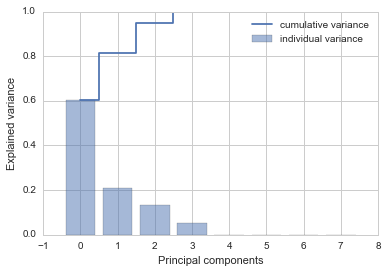

In [17]:
tot = sum(pca.explained_variance_ratio_)
var_exp = [(i/tot) for i in (pca.explained_variance_ratio_)]
cum_var_exp = np.cumsum(var_exp)

ind = np.arange(len(pca.explained_variance_ratio_))
plt.bar(ind, var_exp, alpha=0.5, align='center', label='individual variance')
plt.step(ind, cum_var_exp,where='mid',label='cumulative variance')
plt.xlabel('Principal components')
plt.ylabel('Explained variance')
plt.legend(loc='best')
plt.show()

It tells us that a classifier using the first 4 PCA components would cover mostly all the information

In [22]:
# define the parameter values that should be searched
neighbors = range(1, 40)

### Parameters optimization with gridCVSearch

In [23]:
knn = KNeighborsClassifier()
# create a parameter grid: map the parameter names to the values that should be searched
param_grid = dict(n_neighbors=neighbors)
#print param_grid
# instantiate the grid
grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy')

In [24]:
# fit the grid with data
grid.fit(X, y)

GridSearchCV(cv=10, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

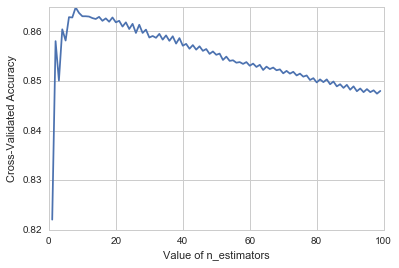

In [21]:
# create a list of the mean scores only
grid_mean_scores = [result.mean_validation_score for result in grid.grid_scores_]
# plot the results
plt.plot(neighbors, grid_mean_scores)
plt.xlabel('Value of n_estimators')
plt.ylabel('Cross-Validated Accuracy')

It looks like k ~ 3-5 is the best value. 
Let's try to optimize several hyperparameters of the Knn classifier at the same time

In [25]:
# define the KNN grid parameters
neighbors = range(1,20)
weights = ['uniform','distance']
algo = ['auto', 'ball_tree', 'kd_tree', 'brute']
distance = ['euclidean','manhattan','minkowski']

pipe_knn_g = Pipeline([('clf',KNeighborsClassifier())])     

param_grid_knn = [{'clf__n_neighbors':neighbors,
                   'clf__algorithm':algo,
                   'clf__metric':distance,
                   'clf__weights':weights}]

In [26]:
gs = GridSearchCV(estimator=pipe_knn_g,
                 param_grid = param_grid_knn,
                 scoring='accuracy',
                 cv=10)

In [27]:
gs = gs.fit(X,y)
print(gs.best_params_)
print(gs.best_score_)

{'clf__metric': 'manhattan', 'clf__weights': 'distance', 'clf__algorithm': 'auto', 'clf__n_neighbors': 8}
0.872712808274


In [28]:
KnnBest = KNeighborsClassifier(metric='manhattan',weights='distance',algorithm='auto',n_neighbors=8)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

In [31]:
print KnnBest
start_time = time.time()
KnnBest.fit(X_train,y_train)
print "Total time took %f seconds" % (time.time()-start_time)
y_pred = KnnBest.predict(X_test)
print metrics.accuracy_score(y_test, y_pred)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
           metric_params=None, n_jobs=1, n_neighbors=8, p=2,
           weights='distance')
Total time took 0.009594 seconds
0.86522869818


In [32]:
prediction_knn = KnnBest.predict_proba(X_test)
y_pred_knn = prediction_knn[:,1]
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test, y_pred_knn)
roc_auc_knn = auc(fpr_knn,tpr_knn)

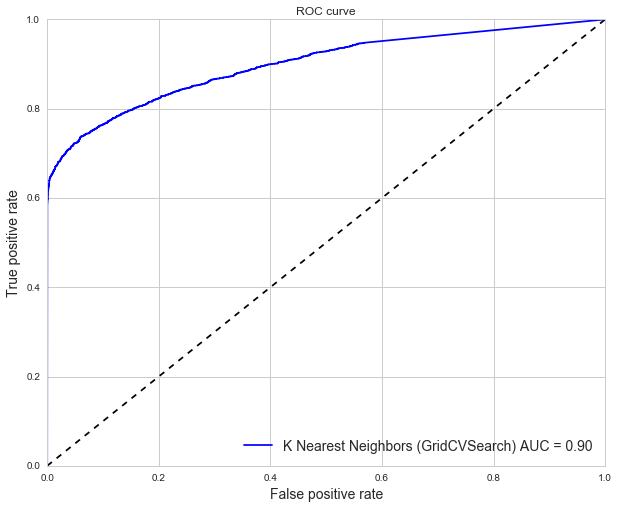

In [33]:
plt.figure(figsize=(10,8))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_knn, tpr_knn, 'b',label = 'K Nearest Neighbors (GridCVSearch) AUC = %0.2f' % roc_auc_knn)
plt.xlabel('False positive rate',fontsize=14)
plt.ylabel('True positive rate',fontsize=14)
plt.title('ROC curve')
plt.legend(loc='best',prop={'size':14})
plt.show()